best params: {'poly__degree': 2, 'ridge__alpha': 1, 'scaler__with_mean': True, 'scaler__with_std': True}
best Rsquared Score: -0.50


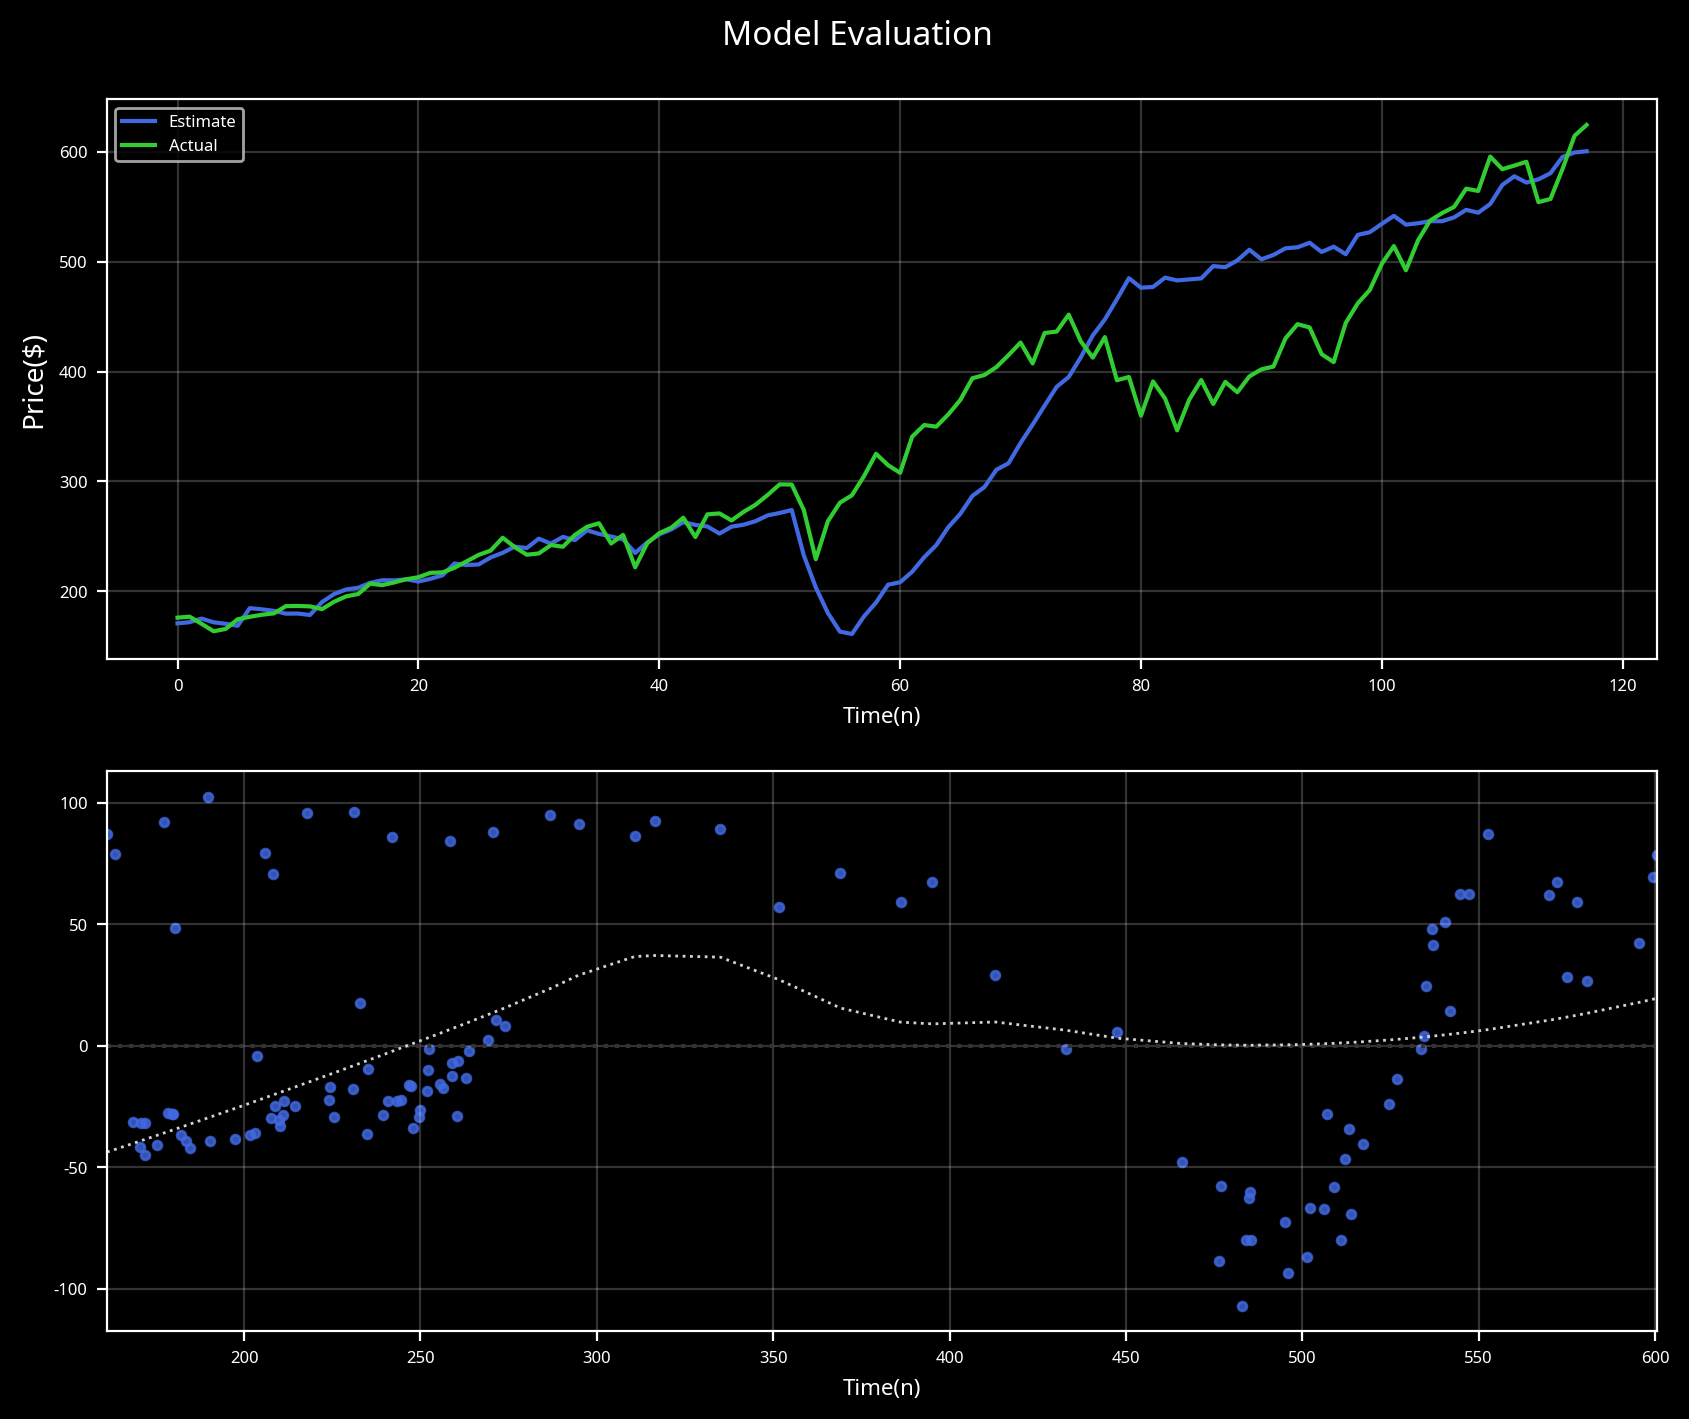

In [1]:
import pandas as pd
from fredapi import Fred
import json
import yfinance as yf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV,train_test_split,TimeSeriesSplit
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
plt.style.use('dark_background')

with open('configs.json','r') as file:
    key = json.load(file)['fred_api_key']
    
fred = Fred(key)

class GetData:
    def __init__(self,ticker,itvl='1mo'):
        self.folder = 'data'
        self.ticker = ticker
        self.interval = itvl
        self.logger = logging.getLogger(__name__)
        if not os.path.exists(self.folder):
            os.makedirs(self.folder)
            
    def get_ticker(self):
        if not os.path.exists(f'{self.folder}/{self.ticker}_OHLC.csv'):
            try:
                ticker_data = yf.download(self.ticker,period='max',interval=self.interval,auto_adjust=True,progress=False)
                ticker_data.columns = ['Open','High','Low','Close','Volume']
                ticker_data.to_csv(f'{self.folder}/{self.ticker}_OHLC.csv')
            except Exception as e:
                self.logger.warning(e)
                return None
        else:
            ticker_data = pd.read_csv(f'{self.folder}/{self.ticker}_OHLC.csv',index_col=0,parse_dates=True)
        
        return ticker_data
                
    def get_macroeconomics(self,features):
        merge = []
        for i in features:
            if not os.path.exists(f'{self.folder}/{i}.csv'):
                try:
                    df = fred.get_series(i)
                    df.to_csv(f'{self.folder}/{i}.csv')
                    df.name = i
                    merge.append(df)
                except Exception as e:
                    self.logger.warning(e)
            else:
                df = pd.read_csv(f'{self.folder}/{i}.csv',index_col=0,parse_dates=True)
                merge.append(df)
        
        alldata = pd.concat(merge,join='inner',axis=1)
        return alldata
    
    
if __name__ == '__main__':
    ticker = 'SPY'
    
    logging.basicConfig(level=logging.WARNING)
    obj = GetData(ticker)
    
    ticker_df = obj.get_ticker()['Close']
    
    if ticker_df is not None:
        feature_df = obj.get_macroeconomics(['CPIAUCSL','PPIACO','PCEPILFE','PCEPI','UNRATE','UMCSENT','PAYEMS','FEDFUNDS'])
        
        startdate = ticker_df.index[0]
        
        feature_df = feature_df.loc[(feature_df.index>=startdate)]
        
        enddate = feature_df.index[-1]
        
        ticker_df = ticker_df.loc[ticker_df.index<=enddate]

        
        if len(feature_df) != len(ticker_df):
            print('Lenght mismatch between features and ticker')
            execute = False
        else:
            execute = True
            
        if execute:

            x = feature_df
            y = np.array(ticker_df).reshape(-1,1)

            xtrain,xtest,ytrain,ytest = train_test_split(x,y,random_state=0,train_size=0.7,shuffle=False)

            pipe_inputs = [('scaler',StandardScaler()),('poly',PolynomialFeatures(include_bias=False)),('ridge',Ridge())]

            params = {
                'scaler__with_mean':[True,False],
                'scaler__with_std':[True,False],
                'poly__degree':[1,2,3,4],
                'ridge__alpha':[0.1,1,10,100]
                }

            pipe = Pipeline(pipe_inputs)

            grid = GridSearchCV(pipe,params,cv=TimeSeriesSplit(n_splits=4))

            grid.fit(xtrain,ytrain)
            
            print(f'best params: {grid.best_params_}')
            print(f'best Rsquared Score: {grid.best_score_:.2f}')
            
            model = grid.best_estimator_

            yhat = grid.predict(xtest)

            fig,ax = plt.subplots(2,1,figsize=(10,8))
            fig.suptitle('Model Evaluation',fontsize=12,fontweight='bold',y=0.93)
            ax = ax.ravel()

            ax[0].plot(np.arange(0,len(yhat)),yhat.flatten(),color='royalblue',label='Estimate')
            ax[0].plot(np.arange(0,len(ytest)),ytest.flatten(),color='limegreen',label='Actual')
            ax[0].set_ylabel('Price($)',fontsize=10)
            ax[0].legend(fontsize=6)

            sns.residplot(x=yhat.flatten(),y=ytest.flatten(),lowess=True,line_kws=dict(linestyle='dotted',linewidth=1,color='lightgrey'),scatter_kws=dict(s=10,alpha=0.8,color='royalblue'),ax=ax[1])

            for a in ax:
                a.tick_params(axis='both',labelsize=6)
                a.set_xlabel('Time(n)',fontsize=8)
                a.grid(True,alpha=0.2)
            
            plt.savefig(f'Econs_on_{ticker}.png',dpi=300)
            fig.show()